# Custom Entity Recognition (Proof of Concept)

### Setup

In [1]:
# Setup cell: Install required packages
try:
    import langchain
except ImportError:
    %pip install langchain

try:
    from langchain_community import chat_models
except ImportError:
    %pip install langchain_community

try:
    import dotenv
except ImportError:
    %pip install python-dotenv

try:
    import matplotlib.pyplot as plt
except ImportError:
    %pip install matplotlib
    
try:
    import openai
except ImportError:
    %pip install openai
    
# Load environment variables
from dotenv import load_dotenv
load_dotenv()

True

### Necessary Libraries

In [2]:

import langchain
import os
from model import init_llm
from prompts import get_blurb_prompt, get_eval_with_feature_prompt
import random
import time 
import json
import matplotlib.pyplot as plt

verbose = False
file_path = 'dataset_100.jsonl'
eval_file_path = 'eval.jsonl'

### Utility functions

In [14]:
# Function to randomly select subsets of varying sizes
def select_random_subsets(input_list, num_subsets):
    subsets = []
    list_length = len(input_list)
    
    for _ in range(num_subsets):
        subset_size = random.randint(1, list_length)  # Random subset size
        subset = random.sample(input_list, subset_size)
        subsets.append(subset)
    
    return subsets

def parse_values(data_str):
    # Normalize newline characters and split the string into records based on the ';;' separator
    records = data_str.replace('\n', '').split(';;')
    # Initialize an empty dictionary to store the parsed data
    parsed_data = {}
    # Iterate through each record
    for record in records:
        record = record.strip()
        # Check if the record is not empty
        if record and "NONE" not in record:
            try:
                # Split the record into attribute name and value based on the '::' separator
                attr_name, attr_value = record.split('::')
            except Exception as e:
                print("RECORD:", record)
                print("-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-")
                print(e)
            # Add the attribute and its value to the dictionary only if the value is not empty
            if attr_value != '':
                parsed_data[attr_name] = attr_value
    return parsed_data

# Example string to parse with a newline character and an empty value
data_str_with_newline_and_empty_value = "color::;;\ndimension::;;"

## Generation Phase

In [4]:
# initialize the language model
llm = init_llm()

prompt = get_blurb_prompt()

gen_query_chain = langchain.LLMChain(
        llm=llm,
        prompt=prompt,
        verbose=verbose
    )

c:\Users\Alejandro\anaconda3\envs\gpu2\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
c:\Users\Alejandro\anaconda3\envs\gpu2\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [5]:
# Pre-defined feature sets

# features = ['price', 'phone_number', 'color', 'dimension']
features = ['color', 'dimension', 'price', 'location']
positive = ['color', 'dimension']
negative = ["price", "location"]

colors = ["red", "blue", "green", "yellow", "black", "white", "purple", "orange", "pink", "brown"]
phone_numbers = ["123-456-7890", "234-567-8901", "345-678-9012", "456-789-0123", "567-890-1234", "678-901-2345", "789-012-3456", "890-123-4567", "901-234-5678", "012-345-6789"]
prices = ["$100", "$200", "$300", "$400", "$500", "$600", "$700", "$800", "$900", "$1000"]
dimensions = ["1x1", "2x2", "3x3", "4x4", "5x5", "6x6", "7x7", "8x8", "9x9", "10x10"]
locations = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix", "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose"]

data = {'color': colors, 'location': locations, 'price': prices, 'dimension': dimensions}


In [6]:
# The code selects random feature subsets,
# generates ground truth and negative samples for these features, 
# predicts an output based on these features and values, 
# and then logs all relevant information to a file.

# negative features in this code are those features that are not 
# considered part of the ground truth but are included in the data 
# set to evaluate the performance of the model or system. 
# They provide additional context and help ensure that the model 
# is not just memorizing specific patterns but is genuinely learning 
# to identify and utilize relevant features

random_subsets = select_random_subsets(features, 100)

ground_truths = []

for idx, feature_set in enumerate(random_subsets):

    ground_truth_feature = []
    ground_truth_value = []
    negative_feature = []
    negative_value = []
    
    vals = []
    

    for feature in feature_set:
        if feature == "dimension":
            dim = random.choice(data[feature])
            ground_truth_value.append(dim)
            ground_truth_feature.append(feature)
            vals.append(dim)
        
        if feature == "color":
            col = random.choice(data[feature])
            ground_truth_value.append(col)
            ground_truth_feature.append(feature)
            vals.append(col)

        if feature == "price":
            pri = random.choice(data[feature])
            negative_value.append(pri)
            negative_feature.append(feature)
            vals.append(pri)

        if feature == "phone_number":
            pho = random.choice(data[feature])
            negative_value.append(pho)
            negative_feature.append(feature)
            vals.append(pho)
            
        if feature == "location":
            loc = random.choice(data[feature])
            negative_value.append(loc)
            negative_feature.append(feature)
            vals.append(loc)

    output = gen_query_chain.predict(features=feature_set, values=vals)

    temp = {"Query": output,
            "Feature Set": feature_set, 
            "Values": vals, 
            "Ground Truth Features": ground_truth_feature, 
            "Ground Truth Values": ground_truth_value, 
            "Negative Features": negative_feature, 
            "Negative Values": negative_value}

    with open(file_path, "a") as f:
        json.dump(temp, f)  # Write JSON object
        f.write('\n')       # Add a newline to separate objects

## Evaluation Phase

In [7]:
# initialize the language model
llm = init_llm()

prompt = get_eval_with_feature_prompt()
prompt = get_eval_with_feature_prompt(False)

eval_query_chain = langchain.LLMChain(
        llm=llm,
        prompt=prompt,
        verbose=verbose
    )

In [8]:
# read 'Query' from JSON objects from an input file line by line, 
# uses a prediction function to process each JSON object, 
# and writes the predictions to an output file in JSON format (separated by a newline)
with open(file_path, 'r') as file:
    for line in file:
        content = json.loads(line)
        #output = eval_query_chain.predict(features=positive, post=content['Query'])
        output = eval_query_chain.predict(post=content['Query'])
        
        with open(eval_file_path, "a") as f:
            temp = {"Response": output}
            json.dump(temp, f)  # Write JSON object
            f.write('\n')       # Add a newline to separate objects


In [15]:
# Parse the string and print the result
parsed_data_with_newline_and_empty_value = parse_values(data_str_with_newline_and_empty_value)
parsed_data_with_newline_and_empty_value

def contains_any(big_string, small_strings):
    # Check if at least one of the small strings is in the big string
    for small_string in small_strings:
        if small_string in big_string:
            return True  # Found at least one match
    return False  # No matches found

def is_match(set1_elem, set2):
    for set2_elem in set2:
        if set2_elem.lower() in set1_elem.lower():
            return True
    return False

# Example big string
big_string = "This is a test string to check for the presence of certain smaller strings."

# List of small strings to check against the big string
small_strings = ["test", "absent", "presence", "missing"]

# Check if the big string contains at least one of the small strings
contains_any(big_string, small_strings)


AttributeError: 'list' object has no attribute 'strip'

RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values 

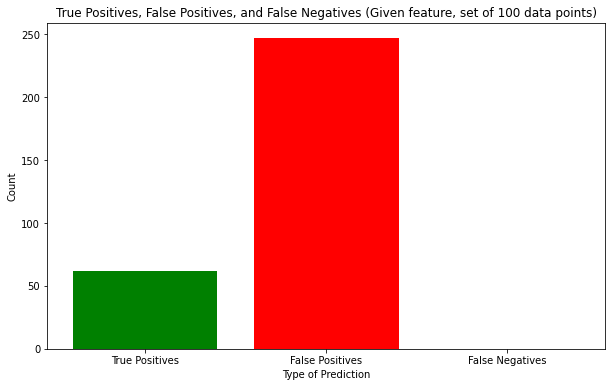

In [10]:
# evaluates the model's predictions by comparing them to ground truth data. 
# It calculates True Positives (correct predictions), 
# False Positives (incorrect predictions), 
# and False Negatives (missed predictions) 
# to measure the performance of the model. 
# The results are stored in the TP, FP, and FN counters.

TP = 0 # True  Positives
FP = 0 # False Positives
FN = 0 # False Negatives

i = 0
with open(eval_file_path, 'r') as file:
    with open(file_path, 'r') as f:
        for line, line2 in zip(file,f):
            
            content = json.loads(line)
            content2 = json.loads(line2)
            
            str = content['Response']
            parsed_data = parse_values(str)
            gtf, gtv = content2['Ground Truth Features'], content2['Ground Truth Values']
            gt = zip(content2['Ground Truth Features'], content2['Ground Truth Values'])
            
            # Get True Positives
            for (feature, value) in gt:
                if feature in parsed_data.keys() and value in parsed_data[feature]:
                    TP += 1
                    
            # Get False Positives
            for (key, val) in zip(parsed_data.keys(), parsed_data.values()):
                if key not in gtf:
                    FP += 1
                elif not contains_any(val, gtv):
                    FP += 1
                    
            # Get False Negatives
            for (feature, value) in gt:
                if feature not in parsed_data.keys():
                    FN += 1
                  
                   

print(TP, FP, FN) 
# bar plot with varying colors
plt.figure(figsize=(10, 6))
plt.bar(['True Positives', 'False Positives', 'False Negatives'], [TP, FP, FN], color=['green', 'red', 'blue'])
plt.xlabel('Type of Prediction')
plt.ylabel('Count')
plt.title('True Positives, False Positives, and False Negatives (Given feature, set of 100 data points)')
plt.show()

Accuracy:  0.20064724919093851
Precision:  0.20064724919093851
Recall:  1.0
F1 Score:  0.33423180592991913


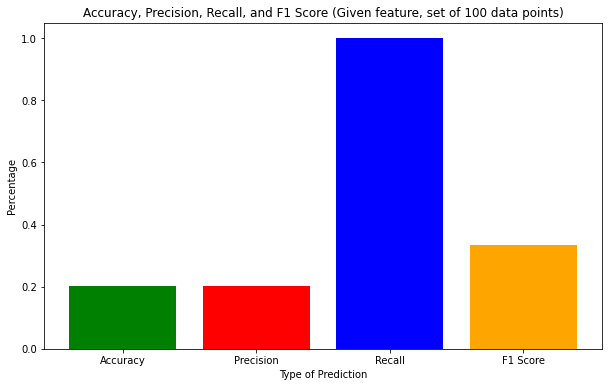

In [11]:
accuracy = TP / (TP + FP + FN)
precisions = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precisions * recall) / (precisions + recall)

print("Accuracy: ", accuracy)
print("Precision: ", precisions)
print("Recall: ", recall)
print("F1 Score: ", f1)
plt.figure(figsize=(10, 6))
plt.bar(['Accuracy', 'Precision', 'Recall', 'F1 Score'], [accuracy, precisions, recall, f1], color=['green', 'red', 'blue', 'orange'])
plt.xlabel('Type of Prediction')
plt.ylabel('Percentage')
plt.title('Accuracy, Precision, Recall, and F1 Score (Given feature, set of 100 data points)')
plt.show()

PARSED VALUES: dict_values([])
AS A SET: set()
MATCHES: 0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
division by zero
PARSED VALUES: dict_values([])
AS A SET: set()
MATCHES: 0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
division by zero
PARSED VALUES: dict_values([])
AS A SET: set()
MATCHES: 0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
division by zero
PARSED VALUES: dict_values([])
AS A SET: set()
MATCHES: 0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
division by zero
PARSED VALUES: dict_values([])
AS A SET: set()
MATCHES: 0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
division by zero
PARSED VALUES: dict_values([])
AS A SET: set()
MATCHES: 0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
division by zero
PARSED VALUES: dict_values([])
AS A SET: set()
MATCHES: 0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
division by zero
PARSED VALUES: dict_values([])
AS A SET: set()
MATCHES: 0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
division by zero
PARSED VALUES: dict_values([])
A

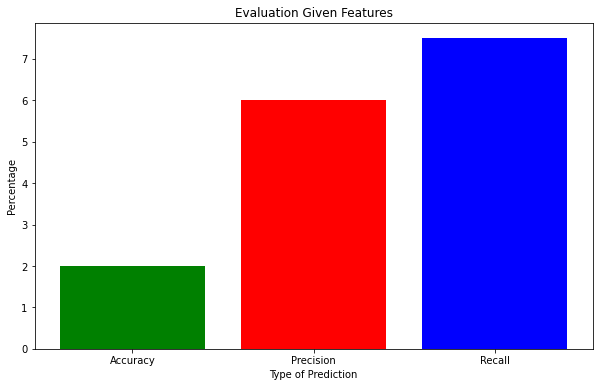

In [12]:
# evaluates the performance of predictions compared to ground truth data

ACC = 0     # Accuracy
PREC = 0    # Precision
REC = 0     # Recall

with open('eval2.jsonl', 'r') as file:
    with open(file_path, 'r') as f:
        for line, line2 in zip(file,f):
            
            content = json.loads(line)
            content2 = json.loads(line2)
            
            str = content['Response']
            parsed_data = parse_values(str)
            gtf, gtv = content2['Ground Truth Features'], content2['Ground Truth Values']
            gt = zip(content2['Ground Truth Features'], content2['Ground Truth Values'])
            
            # Get accuracy, meaning exact match
            match = 0
            if set(parsed_data.keys()) == set(gtf):
                for pred, truth in zip(sorted(parsed_data.values()), sorted(gtv)):
                    if truth in pred:
                        match += 1
                        
                if match == len(gtv):
                    ACC += 1
                    
            # Updated logic to handle empty set cases as specified
            if not parsed_data.values() and not gtv:
                PREC += 1  # Both sets are empty
            elif not gtv and parsed_data.values():
                PREC += 0  # set2 is empty but set1 is not
            else:
                # Count how many elements in set1 have a match in set2 using the is_match function
                matches = sum(is_match(elem, set(gtv)) for elem in set(parsed_data.values()))
                # Calculate the fraction
                try:
                    PREC += matches / len(set(parsed_data.values()))
                except Exception as e:
                    print("PARSED VALUES:", parsed_data.values())
                    print("AS A SET:", set(parsed_data.values()))
                    print("MATCHES:", matches)
                    print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
                    print(e)
            
            # Get Recall, meaning how many of the ground truth values are in the predicted values
            if not parsed_data.values() and not gtv:
                REC += 1
            elif not gtv and parsed_data.values():
                REC += 0
            else:
                matches = sum(is_match(elem, set(gtv)) for elem in set(parsed_data.values()))
                REC += matches / len(set(gtv))

                   
print(ACC, PREC, REC)
plt.figure(figsize=(10, 6))
plt.bar(['Accuracy', 'Precision', 'Recall'], [ACC, PREC, REC], color=['green', 'red', 'blue'])
plt.xlabel('Type of Prediction')
plt.ylabel('Percentage')
plt.title('Evaluation Given Features')
plt.show()

0
location::beach;;  
view::ocean views;;  
atmosphere::relaxing;;  
parking::tricky during peak hours;;
1
price::$500;; 
location::convenient;;
2
color::brown;;  
style::elegant;;  
appearance::sophisticated;;  
variation::standard;;  
choice_type::classic;;
3
dimensions::3x3 unit;; price::$900;; location::San Diego;;
4
color::brown;;  
dimensions::8x8;;  
price::$600;;  
design::quality and design;;  
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
5
color::vibrant orange;;  
price::$400;;  
dimensions::2x2;;  
quality::high;;  
design::stylish;;  
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
6
price::$400;;  
value::impressive;;  
quality::high;;  
RECORD:   
-=-=-=-=--=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-
not enough values to unpack (expected 2, got 1)
7
color::brown;;  
dimensions::4x4;;  
price::$1000;;  
quality::high;;  
style::modern;;  
RECORD:   
-=-=-=-=--=-=-=--=-=-

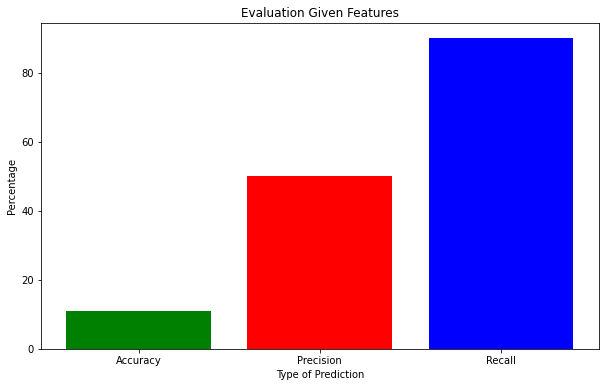

In [13]:
ACC = 0
PREC = 0
REC = 0
i = 0
with open('eval.jsonl', 'r') as file:
    with open(file_path, 'r') as f:
        for line, line2 in zip(file,f):
            print(i)
            i += 1
            content = json.loads(line)
            content2 = json.loads(line2)
            
            str = content['Response']
            print(str)
            parsed_data = parse_values(str)
            gtf, gtv = content2['Ground Truth Features'], content2['Ground Truth Values']
            gt = zip(content2['Ground Truth Features'], content2['Ground Truth Values'])
            
            # Get accuracy, meaning exact match
            match = 0
            if set(parsed_data.keys()) == set(gtf):
                for pred, truth in zip(sorted(parsed_data.values()), sorted(gtv)):
                    if truth in pred:
                        match += 1
                        
                if match == len(gtv):
                    ACC += 1
                    
            # Updated logic to handle empty set cases as specified
            if not parsed_data.values() and not gtv:
                PREC += 1  # Both sets are empty
            elif not gtv and len(set(parsed_data.values())):
                PREC += 0  # set2 is empty but set1 is not
            
            elif len(set(parsed_data.values())) == 0 and len(set(gtv)) != 0:
                PREC += 0
            else:
                # Count how many elements in set1 have a match in set2 using the is_match function
                matches = sum(is_match(elem, set(gtv)) for elem in set(parsed_data.values()))
                # Calculate the fraction
                PREC += matches / len(set(parsed_data.values()))
            
            # Get Recall, meaning how many of the ground truth values are in the predicted values
            if not parsed_data.values() and not gtv:
                REC += 1
            elif not gtv and parsed_data.values():
                REC += 0
            else:
                matches = sum(is_match(elem, set(gtv)) for elem in set(parsed_data.values()))
                REC += matches / len(set(gtv))

                   
print(ACC, PREC, REC)
plt.figure(figsize=(10, 6))
plt.bar(['Accuracy', 'Precision', 'Recall'], [ACC, PREC, REC], color=['green', 'red', 'blue'])
plt.xlabel('Type of Prediction')
plt.ylabel('Percentage')
plt.title('Evaluation Given Features')
plt.show()